In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!export CUDA_VISIBLE_DEVICES=1

In [3]:
from generate import *
import mmcv
from avcv.visualize import *
from avcv.utils import *
from projector import project

In [5]:
# def expand_seed(seeds, vector_size):
#     result = []

#     for seed in seeds:
#     rnd = np.random.RandomState(seed)
#     result.append( rnd.randn(1, vector_size) ) 
#     return result


In [129]:
network_pkl = 'training-runs/00001-dest_gtsr-auto8/network-snapshot-018144.pkl'

device = torch.device('cuda:1')
with dnnlib.util.open_url(network_pkl) as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore

In [7]:
seeds = [0,1,2,3]
outdir = '.cache/00/'
truncation_psi = 1
# !mkdir -p {outdir}
mmcv.mkdir_or_exist(outdir)
noise_mode = 'const'

In [8]:
label = torch.zeros([1, G.c_dim], device=device)

In [133]:
# Generate images
def gen_z(seed, trunc=None):
    
    z = np.random.RandomState(seed).randn(1, G.z_dim)
    if trunc is not None:
        z = np.clip(z, -trunc, trunc)
    
    return torch.from_numpy(z).to(device)
def gen_img(z):
    img = G(z, label, truncation_psi=truncation_psi, noise_mode=noise_mode)
    img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()
    return img

for seed_idx, seed in enumerate(seeds):
    print('Generating image for seed %d (%d/%d) ...' % (seed, seed_idx, len(seeds)))
    z = gen_z(seed)
    img = G(z, label, truncation_psi=truncation_psi, noise_mode=noise_mode)
    img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
    PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB').save(f'{outdir}/seed{seed:04d}.jpg')

Generating image for seed 0 (0/4) ...
Generating image for seed 1 (1/4) ...
Generating image for seed 2 (2/4) ...
Generating image for seed 3 (3/4) ...


In [38]:
# rand_imgs = []
# labels = []
# rand_zs = []
# for i in range(1, 512, 5):
#     z = gen_z(i)
#     rand_zs.append(z)
#     rand_imgs += [gen_img(z)]
#     labels += [i]
# plot_images(rand_imgs, labels, space=[1, 1])

In [119]:
from tqdm import tqdm
def gen_in_between(z1, z2,num_in_between=100):
    imgs = []

    delta = (z2-z1)/num_in_between
    for i in tqdm(range(num_in_between)):
        z = z1+i*delta
        img = gen_img(z)
        imgs.append(img[...,::-1])
    return imgs

def gen_with_direction(z1, delta, num):
    imgs = []
    for i in tqdm(range(-num//2, num//2)):
        z = z1+i*delta
        img = gen_img(z)
        imgs.append(img[...,::-1])
    return imgs


# Generate one class

In [88]:
from glob import glob
from PIL import Image
paths = glob('/data/tsd/classification/GTSRB/train/0/*')
imgs = [mmcv.imread(path, channel_order='rgb') for path in paths]
imgs = [mmcv.imresize(img, (64,64)) for img in imgs]
imgs = [torch.from_numpy(img).float().permute(2,0,1).to(device) for img in imgs]
Image.open(paths[0])

In [89]:
z0 = gen_z(0)

In [90]:
min_val = z0.min()
max_val = z0.max()
diff = max_val - min_val

In [91]:
def put_text(image, pos, text, color=(255, 255, 255), scale=2):
    import cv2
    return cv2.putText(image, text, pos, cv2.FONT_HERSHEY_SIMPLEX, 0.3,
                       color, scale)

In [113]:
# from tqdm import tqdm
# laten_idx = 0
# imgs = []
# step = 60
# for laten_idx in tqdm(range(0, 512)):
#     for i in range(step):
#         _z = z0

#         _z[0, laten_idx] = min_val + i*diff

#         img = gen_img(_z)
#         img = put_text(img.copy(), (2, 15),f'{laten_idx:03d}', scale=1, )
#         imgs += [img[...,::-1]]
# # show(img, dpi=10)
# images_to_video(imgs, '.cache/t2.mp4')

2021-12-18 16:28:50.549 | INFO     | avcv.visualize:plot_images:29 - Grid size: (5, 5)


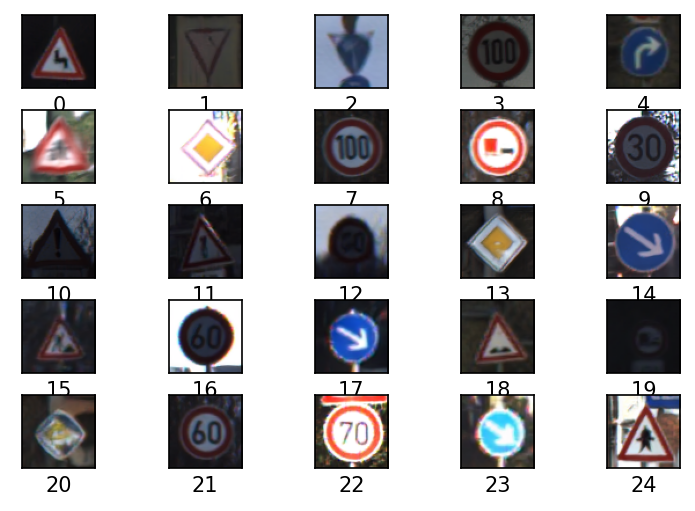

2021-12-18 16:28:52.624 | INFO     | avcv.visualize:plot_images:29 - Grid size: (5, 5)


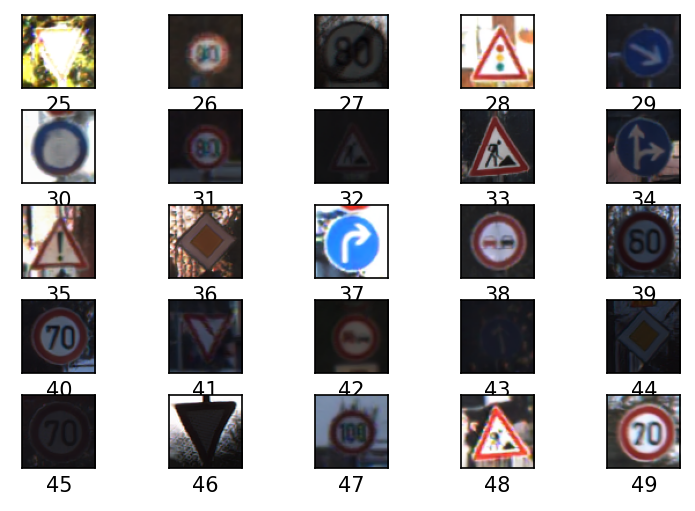

2021-12-18 16:28:54.408 | INFO     | avcv.visualize:plot_images:29 - Grid size: (5, 5)


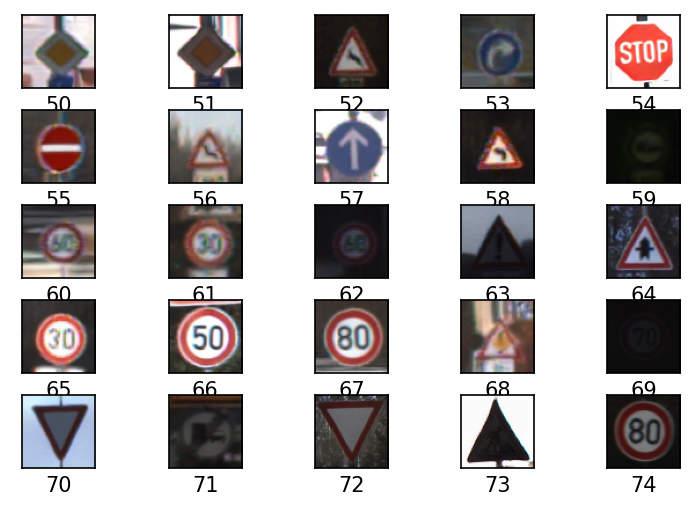

2021-12-18 16:28:56.434 | INFO     | avcv.visualize:plot_images:29 - Grid size: (5, 5)


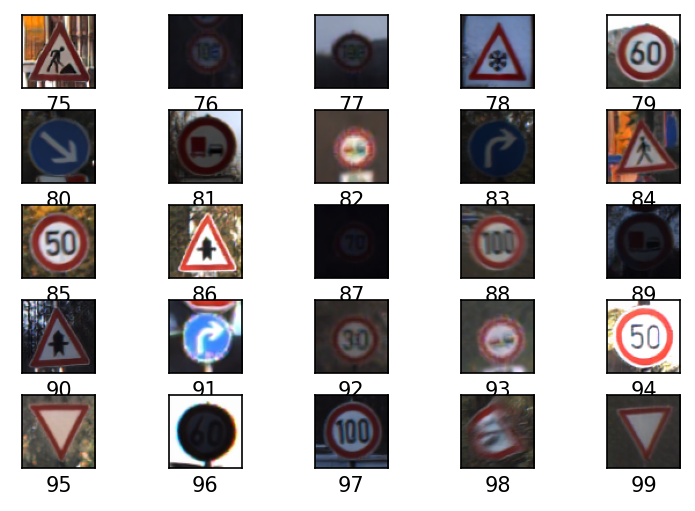

In [138]:
imgs = []
lbls = []
for i in range(100):
    z = gen_z(i)
    img = gen_img(z)
    imgs += [img]
    lbls.append(i)
    if len(imgs) == 25:
        plot_images(imgs[:25], lbls[:25], dpi=150)
        imgs, lbls = [], []

In [152]:
z1 = gen_z(87, trunc=None)
z2 = gen_z(86, trunc=None)
imgs = gen_in_between(z1, z2, 100)
images_to_video(imgs, '.cache/t2.mp4')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 57.54it/s]

[>>>>>>>>>>>>>                ] 46/100, 1836.1 task/s, elapsed: 0s, ETA:     0s

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 100/100, 2040.7 task/s, elapsed: 0s, ETA:     0s

2021-12-18 16:37:47.072 | INFO     | avcv.process:multi_thread:29 - multi_thread
2021-12-18 16:37:47.073 | INFO     | avcv.utils:images_to_video:157 - fWrite video, output_size: {output_size}


[                                                  ] 0/100, elapsed: 0s, ETA:

2021-12-18 16:37:47.074 | INFO     | avcv.utils:images_to_video:159 - out_path: .cache/t2.mp4


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 100/100, 1337.8 task/s, elapsed: 0s, ETA:     0s

In [144]:
# distance = (z1-z2)

tensor([[ 3.2213e+00,  1.1289e+00, -7.7937e-01,  9.1574e-01,  2.0429e+00,
         -1.5253e+00, -8.8335e-01, -1.0609e+00,  8.0630e-01, -8.9708e-01,
          3.8004e-01,  2.3846e+00, -2.8891e-01,  1.1945e+00, -2.3881e-01,
          1.1142e-01, -2.8694e-01,  6.6454e-02,  1.4660e+00, -2.3953e+00,
         -3.1425e+00, -1.4030e+00,  2.0984e-01,  2.1591e+00,  1.4993e+00,
          1.1193e+00,  1.4701e+00,  4.1535e-01, -5.5995e-01,  2.2105e+00,
          6.9728e-02,  2.6749e-01, -9.4698e-01, -9.0530e-01,  2.5565e+00,
          8.7715e-01, -3.4703e-02, -1.6042e+00,  4.9855e-01, -7.2082e-01,
         -6.5830e-01, -1.4797e+00, -2.1179e-01, -1.2856e-01, -1.2575e+00,
          3.7456e-01,  2.6775e+00, -6.7014e-01,  1.6822e+00,  3.9466e-02,
          1.1574e+00, -5.8234e-01,  4.2267e-01,  5.2511e-01,  3.1769e+00,
         -1.6096e+00,  5.6295e-01,  1.2943e+00, -4.6038e-01, -2.4590e-01,
         -2.5395e+00,  1.1284e-02,  2.5978e+00,  6.8148e-01, -1.5078e+00,
         -3.1181e+00,  6.1204e-01, -2.